### Target
Control the Learning Rate as an inverse factor of test accuracy
Introduce rotation in data augmentation
Introduce dropout in all the layers of the model.

### Result

*   Parameters : 7,854
*   Best Train Accuracy : 99.43
* Best Test Accuracy : 99.43

### Analysis

*   Test Accuracy 99.4 consistent over last 10 epochs.
*   Test and train accuracy are tracking very closely
* Seeing the wrong image set, we can conclude that it is difficult even for a human to predict those images correctly.

### **Import Libraries**

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### **The Model**

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) #output=26
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 8, 3) #24
        self.bn2 = nn.BatchNorm2d(8)
        
        self.conv3 = nn.Conv2d(8, 12, 3) #22
        self.bn3 = nn.BatchNorm2d(12)
        self.pool1 = nn.MaxPool2d(2, 2)#11

        self.conv4 = nn.Conv2d(12, 12, 3)#9
        self.bn4 = nn.BatchNorm2d(12)
                
        self.conv5 = nn.Conv2d(12, 16, 3)#7
        self.bn5 = nn.BatchNorm2d(16)
        
        self.conv6 = nn.Conv2d(16, 20, 3)#5
        self.bn6 = nn.BatchNorm2d(20)
        self.pool2 = nn.AvgPool2d(5)#1
        
        self.fc1 = nn.Linear(20,10)
        self.dropout = nn.Dropout(0.02)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool1(self.bn3(F.relu(self.conv3(x))))
        x = self.dropout(x)

        x = self.bn4(F.relu(self.conv4(x)))
        x = self.dropout(x)
        
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.pool2(x)
        
        x = x.view(-1,20)

        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

### **Model Params**

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             584
       BatchNorm2d-5            [-1, 8, 24, 24]              16
           Dropout-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 12, 22, 22]             876
       BatchNorm2d-8           [-1, 12, 22, 22]              24
         MaxPool2d-9           [-1, 12, 11, 11]               0
          Dropout-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 12, 9, 9]           1,308
      BatchNorm2d-12             [-1, 12, 9, 9]              24
          Dropout-13             [-1, 12, 9, 9]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


CUDA Available? True


### **Data Transformations**

In [5]:
#torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.CenterCrop(26),
                        transforms.RandomRotation((-5.0, 5.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### **Train and Test**

In [12]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
    #pbar = tqdm(train_loader)
    for epoch in range(15):
      model.train()
      correct = 0
      loss = 0
      processed = 0
    
      for data, target in train_loader:
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = F.nll_loss(output, target)
          train_losses.append(loss)
          loss.backward()
          optimizer.step()
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)
          train_acc.append(100*correct/processed)

        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

      print('Train set: Accuracy: {}/{} ({:.1f}%)'.format(
        correct, len(train_loader.dataset),
          100. * correct / len(train_loader.dataset)))

      count = 0
      flag = 1

      acc = test(model, device, test_loader)
      print('Test accuracy:{}%'.format(acc))
      if acc >= 99.3 and flag == 2:
        print ('reducing lr')
        scheduler.step()
        flag = 3
      elif acc >= 99.1 and flag == 1:
        print ('reducing lr')
        scheduler.step ()
        flag = 2
      if acc >= 99.4:
        print ('reducing lr')
        scheduler.step ()
        scheduler.step()
        count += 1
      else:
        count = 0
      if count == 3:
        break

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc = 100. * correct / len(test_loader.dataset)
    test_acc.append(acc)

    # #print('\nTest set: Average loss: {:.1f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    
    return acc

In [13]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=1, gamma=0.3)

train(model, device, train_loader, optimizer)
test(model, device, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train set: Accuracy: 57115/60000 (95.2%)
Test accuracy:98.12%
Train set: Accuracy: 59050/60000 (98.4%)
Test accuracy:98.98%
Train set: Accuracy: 59219/60000 (98.7%)
Test accuracy:99.01%
Train set: Accuracy: 59303/60000 (98.8%)
Test accuracy:99.19%
reducing lr
Train set: Accuracy: 59556/60000 (99.3%)
Test accuracy:99.35%
reducing lr
Train set: Accuracy: 59628/60000 (99.4%)
Test accuracy:99.42%
reducing lr
reducing lr
Train set: Accuracy: 59633/60000 (99.4%)
Test accuracy:99.44%
reducing lr
reducing lr
Train set: Accuracy: 59633/60000 (99.4%)
Test accuracy:99.41%
reducing lr
reducing lr
Train set: Accuracy: 59649/60000 (99.4%)
Test accuracy:99.42%
reducing lr
reducing lr
Train set: Accuracy: 59659/60000 (99.4%)
Test accuracy:99.44%
reducing lr
reducing lr
Train set: Accuracy: 59650/60000 (99.4%)
Test accuracy:99.42%
reducing lr
reducing lr
Train set: Accuracy: 59644/60000 (99.4%)
Test accuracy:99.41%
reducing lr
reducing lr
Train set: Accuracy: 59626/60000 (99.4%)
Test accuracy:99.42%
re

99.43

Text(0.5, 1.0, 'Test Accuracy')

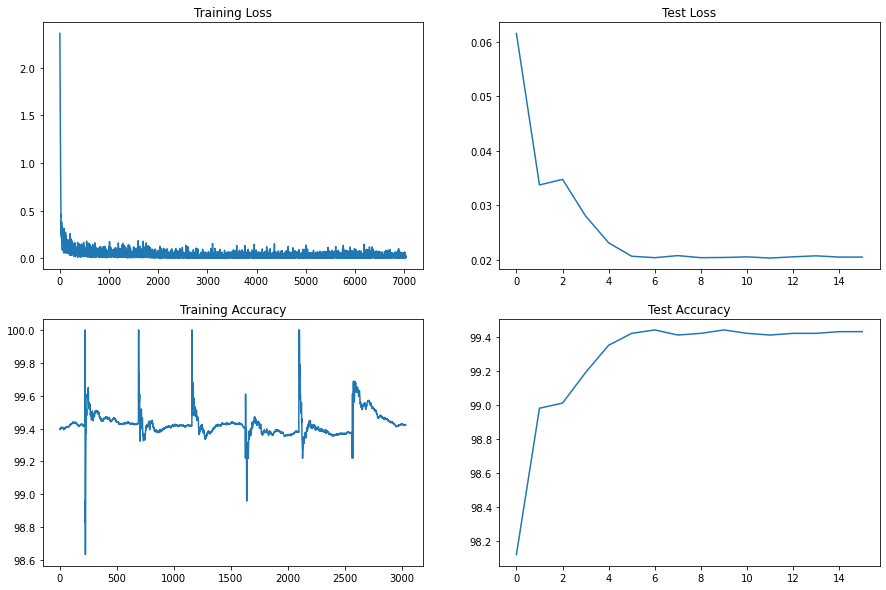

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [15]:
import numpy as np
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [16]:
correct = []
wrong = []
for i in range (20):
  images, labels = next (iter (test_loader))

  img = images
  # Turn off gradients to speed up this part
  with torch.no_grad():
      logps = model (img.cuda())

  # Output of the network are log-probabilities, need to take exponential for probabilities
  ps = torch.exp (logps)
  probabs = []
  for j, element in enumerate (ps):
      pred = torch.argmax(element)
      if pred == labels[j].item ():
          correct.append ([img[j], ps[j], pred, labels[j].item ()])
      else:
          wrong.append ([img[j], ps[j], pred, labels[j].item ()])

len (correct), len (wrong)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(2545, 15)

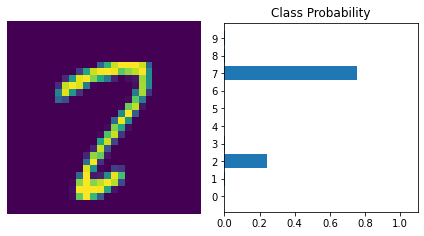

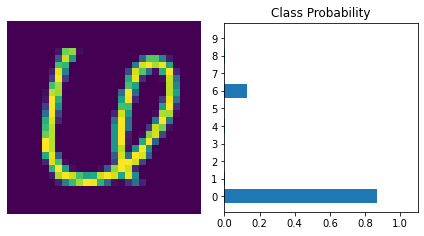

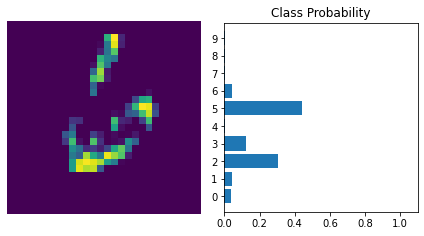

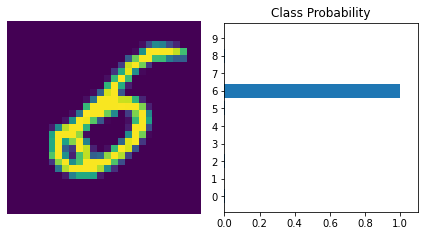

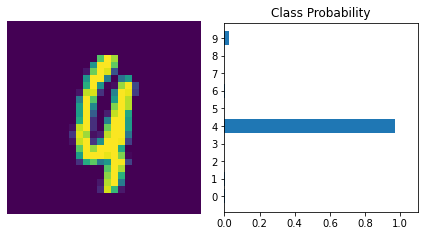

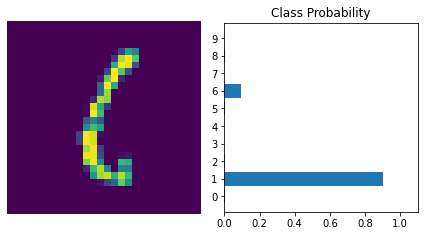

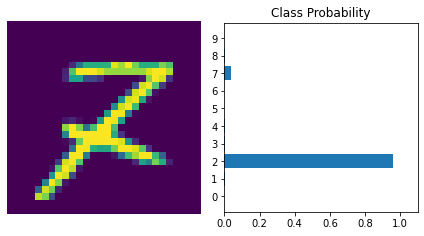

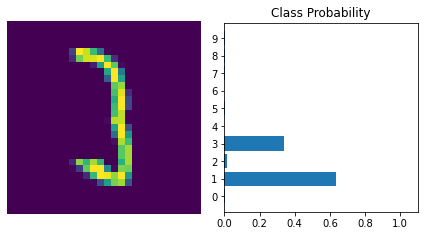

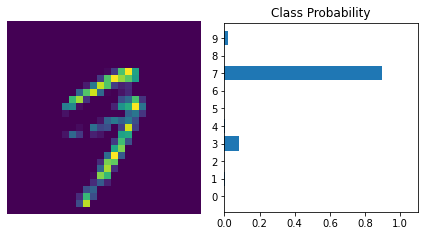

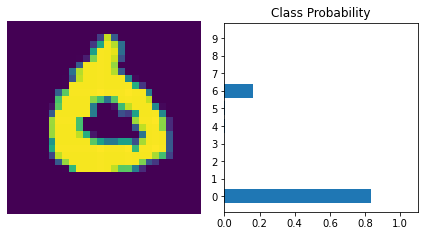

In [18]:
for i in range (10):
  view_classify (wrong[i][0], wrong[i][1])